# Description

This notebook loads the result of running 100 iterations of the CPM algorithm on real data, and also those of running 10,000 iterations with randomized labels (null distribution).

Using these data, the notebook then computes non-parametric p-values for each prediction.

Finally, the notebook generates summary figures for the ability of CPM to predict experiential variables.

> **NOTE:** Although the notebook loads and computes values for the three CPM models (pos, neg and glm), ultimately on the paper we only report results for the glm case.
>
> **NOTE:** Run with kernel display name "FC Instropection (2023 | 3.10)"

In [1]:
import pandas as pd
import os.path as osp
from utils.basics import RESOURCES_CPM_DIR
import hvplot.pandas
from tqdm import tqdm
import numpy as np
import pickle
from utils.basics import FB_400ROI_ATLAS_NAME
from cpm.plotting import plot_predictions
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import xarray as xr
from statsmodels.stats.multitest import multipletests

In [2]:
print('hvplot version: %s' % str(hvplot.__version__))
print('xr version: %s' % str(xr.__version__))
print('pandas version: %s' % str(pd.__version__))

hvplot version: 0.9.2
xr version: 2023.6.0
pandas version: 1.5.0


In [3]:
ACCURACY_METRIC      = 'pearson'
CORR_TYPE            = 'pearson'
E_SUMMARY_METRIC     = 'sum'
CONFOUNDS            = 'conf_residualized'
# How Behaviors are encoded so far
BEHAVIOR_LIST        = ['Factor1','Factor2','Vigilance','Images','Words','People','Myself','Positive','Negative','Surroundings','Intrusive','Future','Past','Specific']
# New labels for consistency with text descriptions
BEHAVIOR_LABELS_DICT = {'Factor1':'Thought Pattern 1','Factor2':'Thought Pattern 2','Vigilance':'Wakefulness',
                        'Images':'Images','Words':'Words','People':'People','Myself':'Myself','Positive':'Positive','Negative':'Negative','Surroundings':'Surroundings','Intrusive':'Intrusive','Future':'Future','Past':'Past','Specific':'Specific'}
BEHAVIOR_LABELS      = ['Thought Pattern 1','Thought Pattern 2','Wakefulness','Images','Words','People','Myself','Positive','Negative','Surroundings','Intrusive','Future','Past','Specific']
# Mode used for running CPM
SPLIT_MODE           = 'subject_aware'
# Atlas Selection
ATLAS                = FB_400ROI_ATLAS_NAME

## 1. Load CPM results

1.1. Real data

In [4]:
%%time
real_results_path = osp.join(RESOURCES_CPM_DIR,f'real-{ATLAS}-{SPLIT_MODE}-{CONFOUNDS}-{CORR_TYPE}_{E_SUMMARY_METRIC}.pkl')
with open(real_results_path,'rb') as f:
     real_predictions_xr = pickle.load(f)
Nbehavs, Niters_real, Nscans, Nresults = real_predictions_xr.shape
print(Nbehavs, Niters_real, Nscans, Nresults)

14 100 471 4
CPU times: user 2.83 ms, sys: 16 ms, total: 18.8 ms
Wall time: 18.6 ms


In [5]:
print(real_results_path)

/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/cpm/real-Schaefer2018_400Parcels_7Networks_AAL2-subject_aware-conf_residualized-pearson_sum.pkl


Updating Behavior coordinate dimensions for proper labeling of final figures so that they agree with the main text

In [6]:
real_predictions_xr = real_predictions_xr.assign_coords({'Behavior':[BEHAVIOR_LABELS_DICT[b] for b in real_predictions_xr.Behavior.values]})

1.2. Randomized data

In [7]:
%%time
null_results_path = osp.join(RESOURCES_CPM_DIR,f'null-{ATLAS}-{SPLIT_MODE}-{CONFOUNDS}-{CORR_TYPE}_{E_SUMMARY_METRIC}.pkl')

with open(null_results_path,'rb') as f:
     null_predictions_xr = pickle.load(f)
_, Niters_null, _, _ = null_predictions_xr.shape
print(Nbehavs, Niters_null, Nscans, Nresults)

14 10000 471 4
CPU times: user 1.24 ms, sys: 945 ms, total: 946 ms
Wall time: 948 ms


In [8]:
print(null_results_path)

/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/cpm/null-Schaefer2018_400Parcels_7Networks_AAL2-subject_aware-conf_residualized-pearson_sum.pkl


In [9]:
null_predictions_xr = null_predictions_xr.assign_coords({'Behavior':[BEHAVIOR_LABELS_DICT[b] for b in null_predictions_xr.Behavior.values]})

# 2. Compute accuracy values

2.1. Real data

In [10]:
%%time
accuracy_real          = {BEHAVIOR:pd.DataFrame(index=range(Niters_real), columns=['Accuracy']) for BEHAVIOR in BEHAVIOR_LABELS}
accuracy_real_Spearman = {BEHAVIOR:pd.DataFrame(index=range(Niters_real), columns=['Accuracy']) for BEHAVIOR in BEHAVIOR_LABELS}

p_values          = pd.DataFrame(index=BEHAVIOR_LABELS,columns=['Non Parametric','Parametric'])
p_values_Spearman = pd.DataFrame(index=BEHAVIOR_LABELS,columns=['Non Parametric','Parametric'])

for BEHAVIOR in BEHAVIOR_LABELS:
    for niter in tqdm(range(Niters_real), desc=BEHAVIOR):
        observed  = pd.Series(real_predictions_xr.loc[BEHAVIOR,niter,:,'observed'].values)
        if E_SUMMARY_METRIC == 'ridge':
            predicted = pd.Series(real_predictions_xr.loc[BEHAVIOR,niter,:,'predicted (ridge)'].values)
        else:
            predicted = pd.Series(real_predictions_xr.loc[BEHAVIOR,niter,:,'predicted (glm)'].values)
        accuracy_real[BEHAVIOR].loc[niter]  = observed.corr(predicted, method='pearson')
        accuracy_real_Spearman[BEHAVIOR].loc[niter]  = observed.corr(predicted, method='spearman')
        _,p_values.loc[BEHAVIOR,'Parametric'] = pearsonr(observed,predicted)
        _,p_values_Spearman.loc[BEHAVIOR,'Parametric'] = spearmanr(observed,predicted)

Specific: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 455.93it/s]

CPU times: user 3.1 s, sys: 6.56 ms, total: 3.1 s
Wall time: 3.1 s


In [11]:
median_accuracies = pd.DataFrame(columns=['Pearson R','Spearman R'], index=BEHAVIOR_LABELS)
for BEHAVIOR in BEHAVIOR_LABELS:
    median_accuracies.loc[BEHAVIOR,'Pearson R'] = accuracy_real[BEHAVIOR].median().values[0]
    median_accuracies.loc[BEHAVIOR,'Spearman R'] = accuracy_real_Spearman[BEHAVIOR].median().values[0]

In [12]:
median_accuracies.to_csv('../resources/cpm/final_avg_accuracies.csv')

In [13]:
median_accuracies.infer_objects().round(2)

,Pearson R,Spearman R
Thought Pattern 1,0.15,0.13
Thought Pattern 2,0.21,0.22
Wakefulness,0.28,0.29
Images,0.14,0.11
Words,0.07,0.05
People,0.10,0.10
Myself,0.02,0.02
Positive,-0.01,-0.03
Negative,0.10,0.09
Surroundings,0.17,0.16


2.2. Null data

In [14]:
%%time
accuracy_null = {BEHAVIOR:pd.DataFrame(index=range(Niters_null), columns=['Accuracy']) for BEHAVIOR in BEHAVIOR_LABELS}
for BEHAVIOR in BEHAVIOR_LABELS:
    for niter in tqdm(range(Niters_null), desc=BEHAVIOR):
        observed  = pd.Series(null_predictions_xr.loc[BEHAVIOR,niter,:,'observed'].values)
        if E_SUMMARY_METRIC == 'ridge':
            predicted = pd.Series(null_predictions_xr.loc[BEHAVIOR,niter,:,'predicted (ridge)'].values)
        else:
            predicted = pd.Series(null_predictions_xr.loc[BEHAVIOR,niter,:,'predicted (glm)'].values)
        accuracy_null[BEHAVIOR].loc[niter]  = observed.corr(predicted, method=ACCURACY_METRIC)

Specific: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1056.37it/s]

CPU times: user 2min 12s, sys: 264 ms, total: 2min 13s
Wall time: 2min 13s


# 3. Compute non-parameter p-values

For this, we rely on the null distribution generated via label randomization. 

We use the formula on section 2.4.4 from Finn & Bandettini ["Movie-watching outperforms rest for functional connectivity-based prediction of behavior"](https://www.sciencedirect.com/science/article/pii/S1053811921002408) NeuroImage 2021

In [15]:
p_values.columns.name = 'p-value'
for BEHAVIOR in BEHAVIOR_LABELS:
    p_values.loc[BEHAVIOR,'Non Parametric'] = (((accuracy_null[BEHAVIOR] > accuracy_real[BEHAVIOR].median()).sum() + 1) / (Niters_null+1)).values[0]

In [16]:
p_values.infer_objects().round(3)

p-value,Non Parametric,Parametric
Thought Pattern 1,0.010,0.009
Thought Pattern 2,0.000,0.000
Wakefulness,0.000,0.000
Images,0.018,0.007
Words,0.181,0.218
People,0.073,0.080
Myself,0.377,0.970
Positive,0.586,0.536
Negative,0.082,0.092
Surroundings,0.004,0.000


In [17]:
(reject_bonf, p_values['Non Parametric, FDRbh'], _, _ ) = multipletests(p_values['Non Parametric'],alpha=0.05,method='fdr_bh')

In [18]:
p_values.infer_objects().round(3)

p-value,Non Parametric,Parametric,"Non Parametric, FDRbh"
Thought Pattern 1,0.010,0.009,0.035
Thought Pattern 2,0.000,0.000,0.001
Wakefulness,0.000,0.000,0.001
Images,0.018,0.007,0.050
Words,0.181,0.218,0.282
People,0.073,0.080,0.144
Myself,0.377,0.970,0.447
Positive,0.586,0.536,0.586
Negative,0.082,0.092,0.144
Surroundings,0.004,0.000,0.020


# 4. Generate Prediction-reporting Figures

> **NOTE:** Next cell should be updated to not depend on pandas.append (given it is about to become deprecated). To avoid continous warnings, we ignore those next.

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [20]:
%%time
null_df = pd.DataFrame(columns=['Question','Iteration','R'])
for BEHAVIOR in BEHAVIOR_LABELS:
    for i in tqdm(range(Niters_null), desc=BEHAVIOR):
        null_df = null_df.append({'Question':BEHAVIOR,'Iteration':i,'R':accuracy_null[BEHAVIOR].loc[i].values[0]}, ignore_index=True)

Specific: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 367.64it/s]

CPU times: user 4min 8s, sys: 1.59 s, total: 4min 9s
Wall time: 4min 10s


In [21]:
%%time
real_df = pd.DataFrame(columns=['Question','Iteration','R'])
for BEHAVIOR in BEHAVIOR_LABELS:
    for i in tqdm(range(Niters_real), desc=BEHAVIOR):
        real_df = real_df.append({'Question':BEHAVIOR,'Iteration':i,'R':accuracy_real[BEHAVIOR].loc[i].values[0]}, ignore_index=True)

Specific: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1201.77it/s]

CPU times: user 1.27 s, sys: 17 ms, total: 1.29 s
Wall time: 1.28 s


We will now save these summary views to disk, as we will need them on the next notebook that creates a dashboard that allows a comprehensive exploration of the CPM results.

> **NOTE:** This file is used in S18 Dashboard to load results. If you don't run this cell when new CPM results are available, the Dashboard will present outdated results.

In [22]:
output_path = osp.join(RESOURCES_CPM_DIR,f'cpm_predictions_summary-{SPLIT_MODE}-{CONFOUNDS}-{CORR_TYPE}.pkl')
outputs     = {'real_df':real_df,'null_df':null_df, 'accuracy_real': accuracy_real, 'accuracy_null':accuracy_null, 'p_values':p_values, 'real_predictions_xr':real_predictions_xr, 'null_predictions_xr':null_predictions_xr}
with open(output_path ,'wb') as f:
    pickle.dump(outputs,f)
print('++ INFO: Data written to disk [%s]' % output_path)

++ INFO: Data written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/cpm/cpm_predictions_summary-subject_aware-conf_residualized-pearson.pkl]


## 4.1. Without statistical annotations


In [23]:
median_width = 0.4
sns.set(style='whitegrid')

Text(0.5, 0, 'SNYCQ Item')

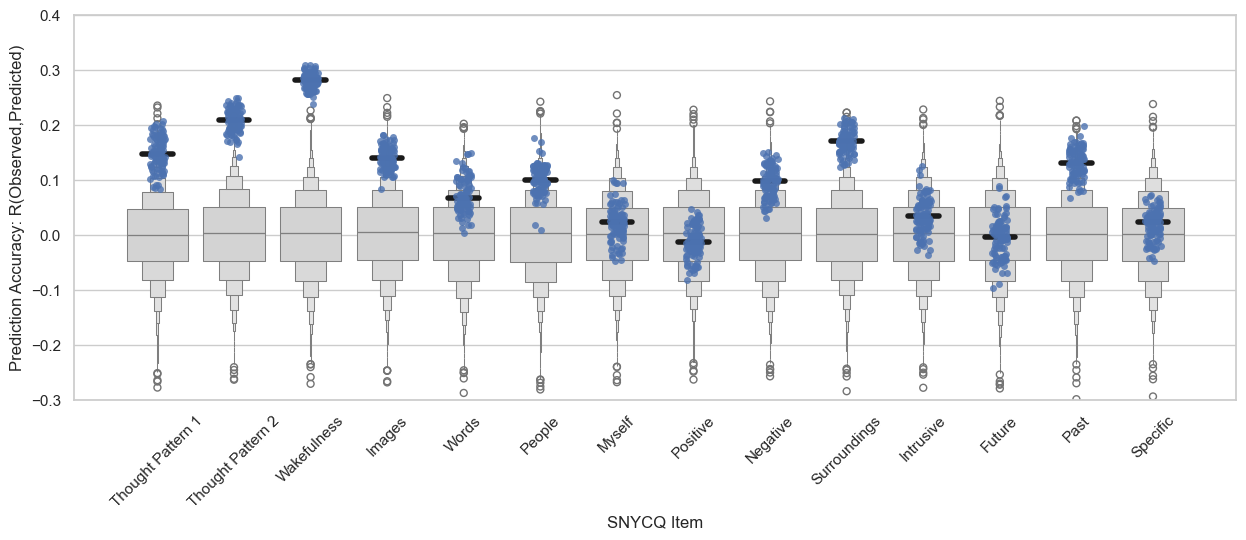

In [24]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
sns.boxenplot(data=null_df,x='Question',y='R', color='lightgray', ax=ax) 
sns.stripplot(data=real_df,x='Question', y='R', alpha=.8, ax=ax)
plt.xticks(rotation=45);
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
    question   = text.get_text()
    median_val = accuracy_real[question].median().values[0]
    ax.plot([tick-median_width/2, tick+median_width/2],[median_val,median_val], lw=4, color='k')
ax.set_ylim(-.3,.4)
ax.set_ylabel('Prediction Accuracy: R(Observed,Predicted)');
ax.set_xlabel('SNYCQ Item')

## 4.2. With Statistical Annotations

Text(0.5, 0, 'SNYCQ Item')

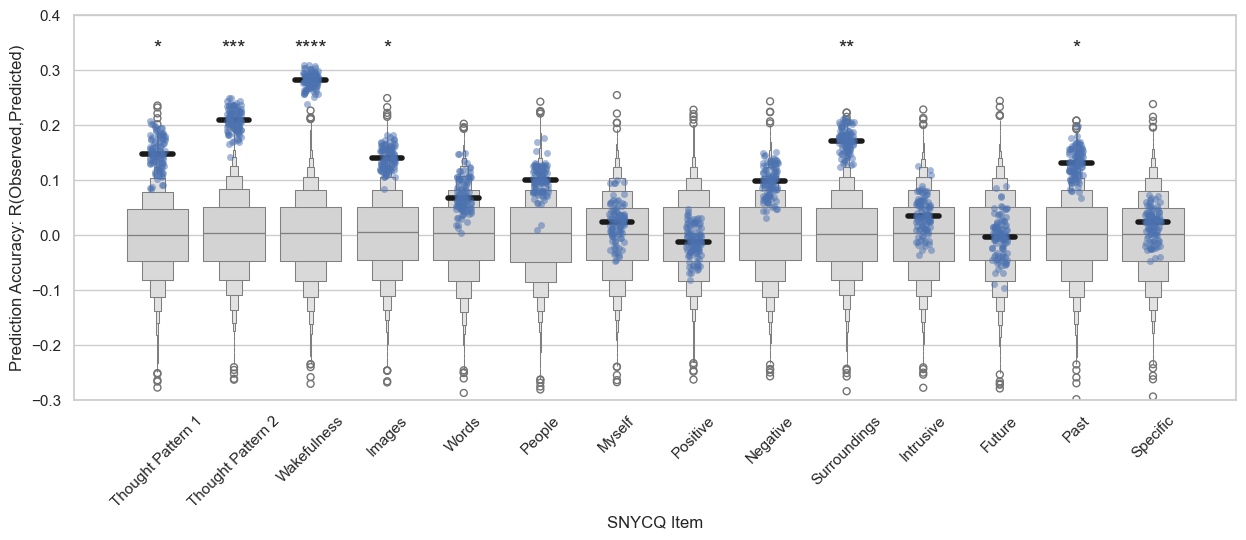

In [25]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
sns.boxenplot(data=null_df,x='Question',y='R', color='lightgray', ax=ax) 
sns.stripplot(data=real_df,x='Question', y='R', alpha=.5, ax=ax)
plt.xticks(rotation=45);
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
    # Add Black Line Signaling Median
    question   = text.get_text()
    median_val = accuracy_real[question].median().values[0]
    ax.plot([tick-median_width/2, tick+median_width/2],[median_val,median_val], lw=4, color='k')
    # Statistical Significant Information
    p = p_values.loc[question,'Non Parametric']
    if 5.00e-02 < p <= 1.00e+00:
        annot = '' 
    elif 1.00e-02 < p <= 5.00e-02:
        annot = '*'
    elif 1.00e-03 < p <= 1.00e-02:
        annot = '**'
    elif 1.00e-04 < p <= 1.00e-03:
        annot = '***'
    elif p <= 1.00e-04:
        annot = '****'
    max_val = real_df.set_index('Question').max()['R']
    ax.annotate(annot, xy=(tick, max_val+0.02), ha='center', fontsize=15)
    
ax.set_ylim(-.3,.4)
ax.set_ylabel('Prediction Accuracy: R(Observed,Predicted)');
ax.set_xlabel('SNYCQ Item')

We will also plot the same results, but separated in three different panels. One for the wakefulness question, one for the two factors, and one for the 11 questions entering the Sparse Box-Constrained Non-Negative Matrix Factorization. This might come handy for presentations, yet it is exactly the same information as above.

Text(0, 0, 'Wakefulness') 0.28
Text(0, 0, 'Thought Pattern 1') 0.15
Text(1, 0, 'Thought Pattern 2') 0.21


/tmp/ipykernel_614056/3527831319.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(['Pattern 1','Pattern 2'])


Text(0, 0, 'Images') 0.14
Text(6, 0, 'Surroundings') 0.17
Text(9, 0, 'Past') 0.13


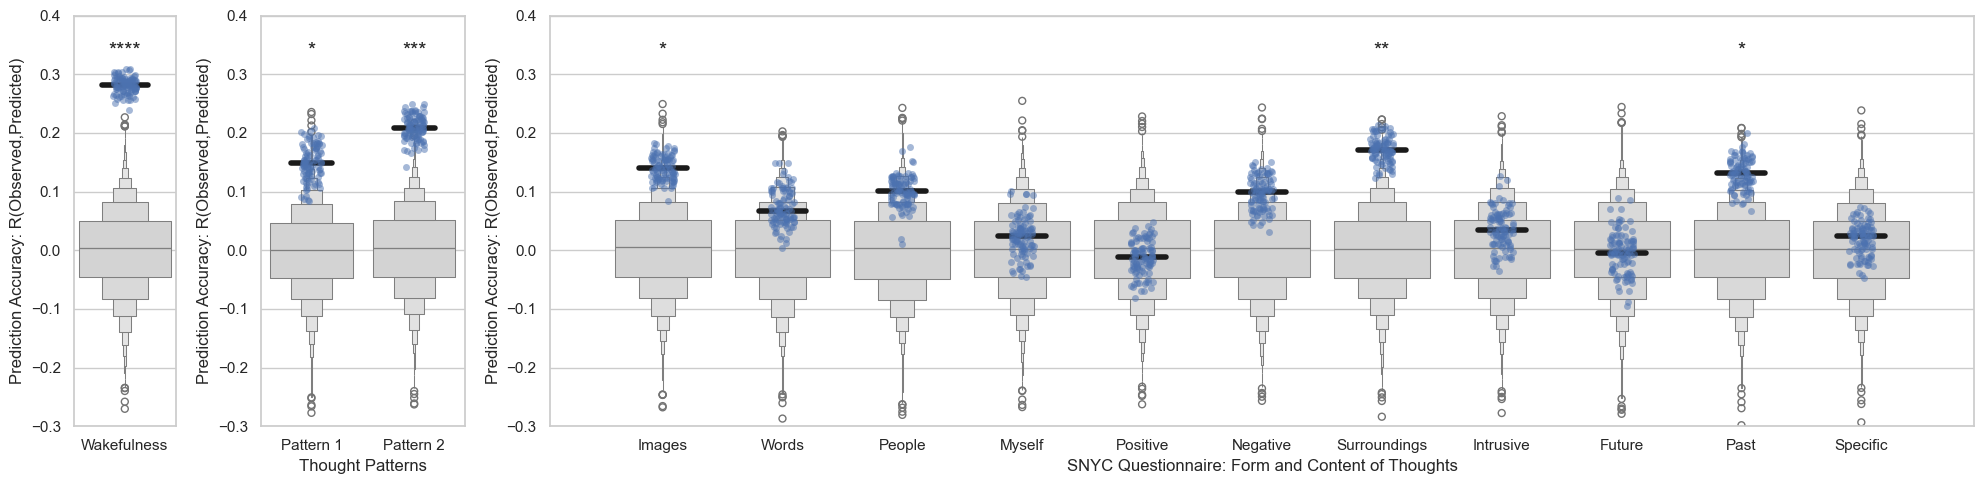

In [26]:
median_width = 0.4
sns.set(style='whitegrid')
fig,ax = plt.subplots(1,3 ,figsize=(20,5), gridspec_kw={'width_ratios': [1,2,14]})
# Vigilance
sns.boxenplot(data=null_df[null_df['Question']=='Wakefulness'],x='Question',y='R', color='lightgray', ax=ax[0]) 
sns.stripplot(data=real_df[real_df['Question']=='Wakefulness'],x='Question', y='R', alpha=.5, ax=ax[0])
for tick, text in zip(ax[0].get_xticks(), ax[0].get_xticklabels()):
    # Add Black Line Signaling Median
    question   = text.get_text()
    median_val = accuracy_real[question].median().values[0]
    print(text, '%.2f' % median_val)
    ax[0].plot([tick-median_width/2, tick+median_width/2],[median_val,median_val], lw=4, color='k')
    # Statistical Significant Information
    p = p_values.loc[question,'Non Parametric']
    if 5.00e-02 < p <= 1.00e+00:
        annot = '' 
    elif 1.00e-02 < p <= 5.00e-02:
        annot = '*'
    elif 1.00e-03 < p <= 1.00e-02:
        annot = '**'
    elif 1.00e-04 < p <= 1.00e-03:
        annot = '***'
    elif p <= 1.00e-04:
        annot = '****'
    max_val = real_df.set_index('Question').max()['R']
    ax[0].annotate(annot, xy=(tick, max_val+0.02), ha='center', fontsize=15)
    
ax[0].set_ylim(-.3,.4)
ax[0].set_ylabel('Prediction Accuracy: R(Observed,Predicted)');
ax[0].set_xlabel('')

# Factors
sns.boxenplot(data=null_df[(null_df['Question']=='Thought Pattern 1') | (null_df['Question']=='Thought Pattern 2')],x='Question', y='R', color='lightgray', ax=ax[1]) 
sns.stripplot(data=real_df[(real_df['Question']=='Thought Pattern 1') | (real_df['Question']=='Thought Pattern 2')],x='Question', y='R', alpha=.5, ax=ax[1])
for tick, text in zip(ax[1].get_xticks(), ax[1].get_xticklabels()):
    # Add Black Line Signaling Median
    question   = text.get_text()
    median_val = accuracy_real[question].median().values[0]
    print(text, '%.2f' % median_val)
    ax[1].plot([tick-median_width/2, tick+median_width/2],[median_val,median_val], lw=4, color='k')
    # Statistical Significant Information
    p = p_values.loc[question,'Non Parametric']
    if 5.00e-02 < p <= 1.00e+00:
        annot = '' 
    elif 1.00e-02 < p <= 5.00e-02:
        annot = '*'
    elif 1.00e-03 < p <= 1.00e-02:
        annot = '**'
    elif 1.00e-04 < p <= 1.00e-03:
        annot = '***'
    elif p <= 1.00e-04:
        annot = '****'
    max_val = real_df.set_index('Question').max()['R']
    ax[1].annotate(annot, xy=(tick, max_val+0.02), ha='center', fontsize=15)
ax[1].set_xticklabels(['Pattern 1','Pattern 2'])
ax[1].set_ylim(-.3,.4)
ax[1].set_ylabel('Prediction Accuracy: R(Observed,Predicted)');
ax[1].set_xlabel('Thought Patterns')

# Individual Iterms
sns.boxenplot(data=null_df[(null_df['Question']!='Thought Pattern 1') & (null_df['Question']!='Thought Pattern 2') & (null_df['Question']!='Wakefulness')],x='Question', y='R', color='lightgray', ax=ax[2]) 
sns.stripplot(data=real_df[(real_df['Question']!='Thought Pattern 1') & (real_df['Question']!='Thought Pattern 2') & (real_df['Question']!='Wakefulness')],x='Question', y='R', alpha=.5, ax=ax[2])
for tick, text in zip(ax[2].get_xticks(), ax[2].get_xticklabels()):
    # Add Black Line Signaling Median
    question   = text.get_text()
    median_val = accuracy_real[question].median().values[0]
    ax[2].plot([tick-median_width/2, tick+median_width/2],[median_val,median_val], lw=4, color='k')
    # Statistical Significant Information
    p = p_values.loc[question,'Non Parametric']
    if 5.00e-02 < p <= 1.00e+00:
        annot = '' 
    elif 1.00e-02 < p <= 5.00e-02:
        annot = '*'
        print(text, '%.2f' % median_val)
    elif 1.00e-03 < p <= 1.00e-02:
        annot = '**'
        print(text, '%.2f' % median_val)
    elif 1.00e-04 < p <= 1.00e-03:
        annot = '***'
        print(text, '%.2f' % median_val)
    elif p <= 1.00e-04:
        annot = '****'
        print(text, '%.2f' % median_val)
    max_val = real_df.set_index('Question').max()['R']
    ax[2].annotate(annot, xy=(tick, max_val+0.02), ha='center', fontsize=15)
    
ax[2].set_ylim(-.3,.4)
ax[2].set_ylabel('Prediction Accuracy: R(Observed,Predicted)');
ax[2].set_xlabel('SNYC Questionnaire: Form and Content of Thoughts')
plt.tight_layout()

In [27]:
fig.savefig('./figures/S17_CPM_subject_aware-PredictionAccuracy.png')

Text(0, 0, 'Wakefulness') 0.28
Text(0, 0, 'Thought Pattern 1') 0.15
Text(1, 0, 'Thought Pattern 2') 0.21


/tmp/ipykernel_614056/1540785016.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(['Pattern 1','Pattern 2'])


Text(0, 0, 'Images') 0.14
Text(1, 0, 'Surroundings') 0.17
Text(2, 0, 'Past') 0.13


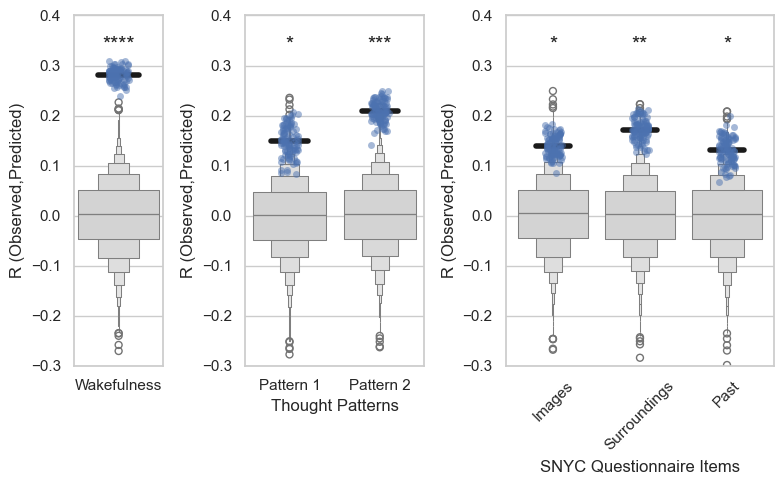

In [28]:
median_width = 0.4
sns.set(style='whitegrid')
fig,ax = plt.subplots(1,3 ,figsize=(8,5), gridspec_kw={'width_ratios': [1,2,3]})
# Vigilance
sns.boxenplot(data=null_df[null_df['Question']=='Wakefulness'],x='Question',y='R', color='lightgray', ax=ax[0]) 
sns.stripplot(data=real_df[real_df['Question']=='Wakefulness'],x='Question', y='R', alpha=.5, ax=ax[0])
plt.xticks(rotation=45);
for tick, text in zip(ax[0].get_xticks(), ax[0].get_xticklabels()):
    # Add Black Line Signaling Median
    question   = text.get_text()
    median_val = accuracy_real[question].median().values[0]
    print(text, '%.2f' % median_val)
    ax[0].plot([tick-median_width/2, tick+median_width/2],[median_val,median_val], lw=4, color='k')
    # Statistical Significant Information
    p = p_values.loc[question,'Non Parametric']
    if 5.00e-02 < p <= 1.00e+00:
        annot = '' 
    elif 1.00e-02 < p <= 5.00e-02:
        annot = '*'
    elif 1.00e-03 < p <= 1.00e-02:
        annot = '**'
    elif 1.00e-04 < p <= 1.00e-03:
        annot = '***'
    elif p <= 1.00e-04:
        annot = '****'
    max_val = real_df.set_index('Question').max()['R']
    ax[0].annotate(annot, xy=(tick, max_val+0.02), ha='center', fontsize=15)
    
ax[0].set_ylim(-.3,.4)
ax[0].set_ylabel('R (Observed,Predicted)');
ax[0].set_xlabel('')

# Factors
sns.boxenplot(data=null_df[(null_df['Question']=='Thought Pattern 1') | (null_df['Question']=='Thought Pattern 2')],x='Question',y='R', color='lightgray', ax=ax[1]) 
sns.stripplot(data=real_df[(real_df['Question']=='Thought Pattern 1') | (real_df['Question']=='Thought Pattern 2')],x='Question', y='R', alpha=.5, ax=ax[1])
plt.xticks(rotation=45);
for tick, text in zip(ax[1].get_xticks(), ax[1].get_xticklabels()):
    # Add Black Line Signaling Median
    question   = text.get_text()
    median_val = accuracy_real[question].median().values[0]
    print(text, '%.2f' % median_val)
    ax[1].plot([tick-median_width/2, tick+median_width/2],[median_val,median_val], lw=4, color='k')
    # Statistical Significant Information
    p = p_values.loc[question,'Non Parametric']
    if 5.00e-02 < p <= 1.00e+00:
        annot = '' 
    elif 1.00e-02 < p <= 5.00e-02:
        annot = '*'
    elif 1.00e-03 < p <= 1.00e-02:
        annot = '**'
    elif 1.00e-04 < p <= 1.00e-03:
        annot = '***'
    elif p <= 1.00e-04:
        annot = '****'
    max_val = real_df.set_index('Question').max()['R']
    ax[1].annotate(annot, xy=(tick, max_val+0.02), ha='center', fontsize=15)

ax[1].set_ylim(-.3,.4)
ax[1].set_xticklabels(['Pattern 1','Pattern 2'])
ax[1].set_ylabel('R (Observed,Predicted)');
ax[1].set_xlabel('Thought Patterns')

# Significant Individual Iterms
sns.boxenplot(data=null_df[(null_df['Question']=='Images') | (null_df['Question']=='Surroundings') | (null_df['Question']=='Past')],x='Question',y='R', color='lightgray', ax=ax[2]) 
sns.stripplot(data=real_df[(real_df['Question']=='Images') | (real_df['Question']=='Surroundings') | (real_df['Question']=='Past')],x='Question', y='R', alpha=.5, ax=ax[2])
plt.xticks(rotation=45);
for tick, text in zip(ax[2].get_xticks(), ax[2].get_xticklabels()):
    # Add Black Line Signaling Median
    question   = text.get_text()
    median_val = accuracy_real[question].median().values[0]
    ax[2].plot([tick-median_width/2, tick+median_width/2],[median_val,median_val], lw=4, color='k')
    # Statistical Significant Information
    p = p_values.loc[question,'Non Parametric']
    if 5.00e-02 < p <= 1.00e+00:
        annot = '' 
    elif 1.00e-02 < p <= 5.00e-02:
        annot = '*'
        print(text, '%.2f' % median_val)
    elif 1.00e-03 < p <= 1.00e-02:
        annot = '**'
        print(text, '%.2f' % median_val)
    elif 1.00e-04 < p <= 1.00e-03:
        annot = '***'
        print(text, '%.2f' % median_val)
    elif p <= 1.00e-04:
        annot = '****'
        print(text, '%.2f' % median_val)
    max_val = real_df.set_index('Question').max()['R']
    ax[2].annotate(annot, xy=(tick, max_val+0.02), ha='center', fontsize=15)
    
ax[2].set_ylim(-.3,.4)
ax[2].set_ylabel('R (Observed,Predicted)');
ax[2].set_xlabel('SNYC Questionnaire Items')
plt.tight_layout()

In [29]:
fig.savefig('./figures/S17_CPM_subject_aware-PredictionAccuracy_onlySignificant.png')

## 4.3. Scatter Plots of Observed vs. Predicted Values

In [30]:
N_sign_results = (p_values.loc[:,'Non Parametric'] < 0.05).sum()
print('++ INFO: Number of items predicted significantly: %d ' % N_sign_results)

++ INFO: Number of items predicted significantly: 6 


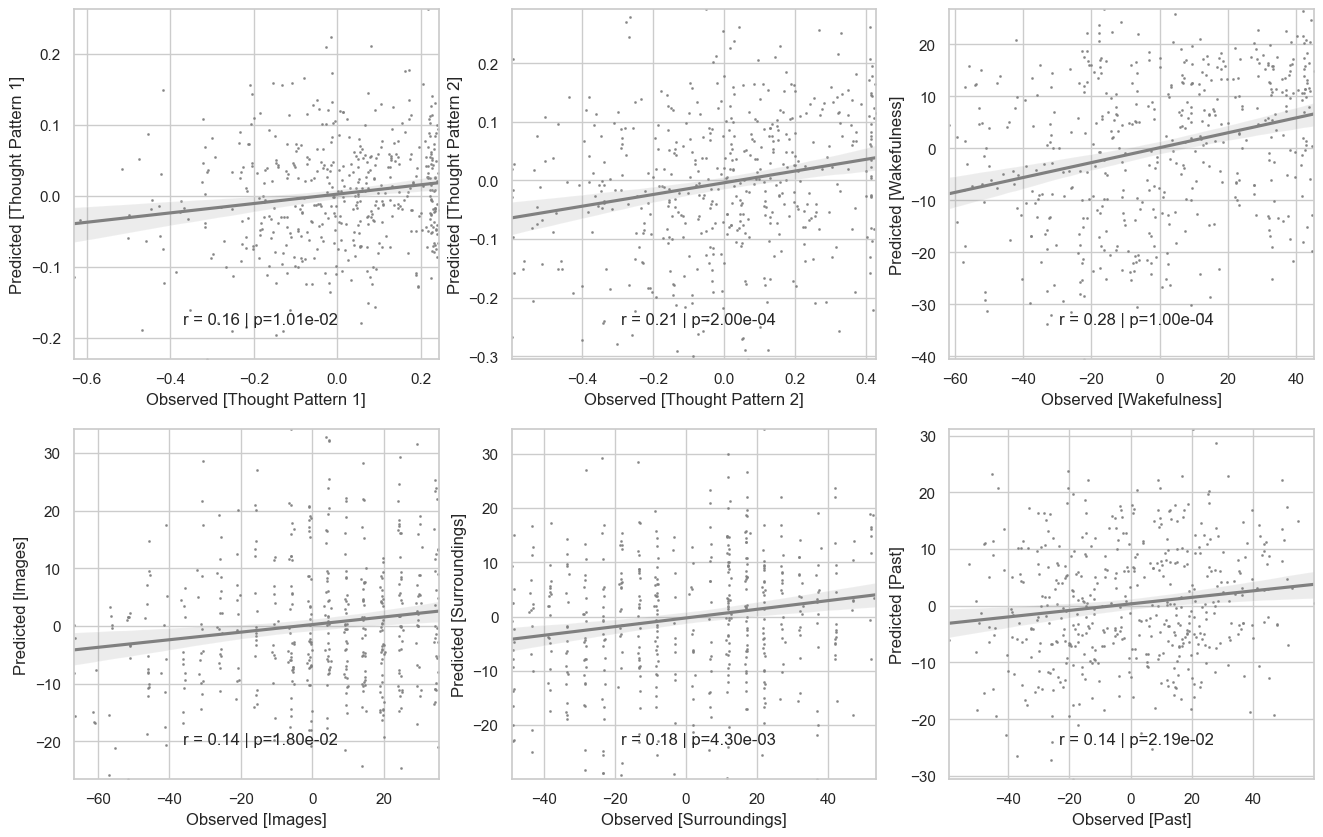

In [31]:
fig,ax = plt.subplots(2,int(N_sign_results/2),figsize=(16,10))
i = 0
for BEHAVIOR in BEHAVIOR_LABELS_DICT.values():
    p = p_values.loc[BEHAVIOR,'Non Parametric']
    if p <= 0.05:
        row,col        = np.unravel_index(i,(2,int(N_sign_results/2)))
        behav_obs_pred = pd.DataFrame(real_predictions_xr.median(dim='Iteration').loc[BEHAVIOR,:,['observed','predicted (glm)']], columns=['observed','predicted (glm)'])
        r,p = plot_predictions(behav_obs_pred, ax=ax[row,col], xlabel='Observed [%s]' % BEHAVIOR, ylabel='Predicted [%s]' % BEHAVIOR, font_scale=1,p_value=p_values.loc[BEHAVIOR,'Non Parametric'], 
                               ylim=(behav_obs_pred['predicted (glm)'].min(), behav_obs_pred['predicted (glm)'].max()),
                               xlim=(behav_obs_pred['observed'].min(), behav_obs_pred['observed'].max()))
        i= i + 1

In [32]:
plt.tight_layout()
fig.savefig('./figures/S17_CPM_subject_aware-ScatterPlots.png')

<Figure size 640x480 with 0 Axes>